In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, OneHotEncoderSeq, RadianEncoder #, MixedEncoder, 
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.predictor_config import PredictionConfig #,SEQ_ENCODING_EXTERNAL DEFAULT_CONF, 
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper #, BaseLinearWrapper
from hamp_pred.src.predictor import Predictor

2023-04-27 10:09:45.208963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 10:09:45.345851: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-27 10:09:45.914173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-27 10:09:45.914271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)


In [3]:
data['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

## Train and validate

In [4]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
        
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [5]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod
    

In [6]:
def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 4, 7)]
    layers = [3]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = (get_rmse(data_val, mod), model_config)
    return results
        

## Tune hiperparameters

In [7]:
opt_res = opt_conf(data, tune=True)  

2023-04-27 10:09:48.624403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 10:09:49.196704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2023-04-27 10:09:53.858462: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-27 10:09:54.097797: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-27 10:09:54.098269: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-27 10:09:54.098292: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-27 10:09:54.098895: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-27 10:09:54.098951: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


63/63 [==============================] - 7s 109ms/sample - loss: 0.0359 - mae: 0.1095 - val_loss: 0.0490 - val_mae: 0.1492 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0162 - mae: 0.0788 - val_loss: 0.0182 - val_mae: 0.0851 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0120 - mae: 0.0688 - val_loss: 0.0174 - val_mae: 0.0833 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0092 - mae: 0.0617 - val_loss: 0.0164 - val_mae: 0.0785 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 1s 18ms/sample - loss: 0.0069 - mae: 0.0546 - val_loss: 0.0175 - val_mae: 0.0789 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0053 - mae: 0.0484 - val_loss: 0.0162 - val_mae: 0.0776 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 1s 18ms/sample - loss: 0.0043 - mae: 0.0440 - val_loss: 0.0168 - val_mae: 0.

Epoch 5/100
63/63 [==============================] - 1s 19ms/sample - loss: 0.0061 - mae: 0.0514 - val_loss: 0.0165 - val_mae: 0.0785 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 1s 19ms/sample - loss: 0.0049 - mae: 0.0464 - val_loss: 0.0160 - val_mae: 0.0783 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 1s 22ms/sample - loss: 0.0039 - mae: 0.0412 - val_loss: 0.0155 - val_mae: 0.0735 - lr: 0.0010
Epoch 8/100
63/63 [==============================] - 1s 19ms/sample - loss: 0.0033 - mae: 0.0383 - val_loss: 0.0170 - val_mae: 0.0774 - lr: 0.0010
Epoch 9/100
63/63 [==============================] - 1s 22ms/sample - loss: 0.0032 - mae: 0.0376 - val_loss: 0.0154 - val_mae: 0.0745 - lr: 0.0010
Epoch 10/100
63/63 [==============================] - 1s 19ms/sample - loss: 0.0028 - mae: 0.0357 - val_loss: 0.0162 - val_mae: 0.0747 - lr: 0.0010
Epoch 11/100
63/63 [==============================] - 1s 19ms/sample - loss: 0.0026 - mae: 0.0344 - val_loss: 0.0157 

63/63 [==============================] - 1s 22ms/sample - loss: 0.0022 - mae: 0.0295 - val_loss: 0.0150 - val_mae: 0.0720 - lr: 0.0010
Epoch 23/100
63/63 [==============================] - 1s 22ms/sample - loss: 0.0016 - mae: 0.0272 - val_loss: 0.0148 - val_mae: 0.0711 - lr: 0.0010
Epoch 24/100
63/63 [==============================] - 1s 22ms/sample - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0144 - val_mae: 0.0716 - lr: 0.0010
Epoch 25/100
63/63 [==============================] - 1s 22ms/sample - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0150 - val_mae: 0.0721 - lr: 0.0010
Epoch 26/100
 0/63 [..............................] - ETA: 0s - loss: 0.0013 - mae: 0.0246
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
63/63 [==============================] - 1s 22ms/sample - loss: 0.0013 - mae: 0.0246 - val_loss: 0.0148 - val_mae: 0.0713 - lr: 0.0010
Epoch 27/100
63/63 [==============================] - 2s 25ms/sample - loss: 8.3983e-04 - mae: 0.0197 - val_loss: 0.0

Epoch 21/100
63/63 [==============================] - 1s 23ms/sample - loss: 8.3226e-04 - mae: 0.0197 - val_loss: 0.0144 - val_mae: 0.0704 - lr: 1.0000e-05
Epoch 22/100
63/63 [==============================] - 1s 23ms/sample - loss: 8.5229e-04 - mae: 0.0200 - val_loss: 0.0144 - val_mae: 0.0704 - lr: 1.0000e-05
Epoch 23/100
63/63 [==============================] - 1s 23ms/sample - loss: 8.3617e-04 - mae: 0.0198 - val_loss: 0.0144 - val_mae: 0.0703 - lr: 1.0000e-05
Epoch 24/100
63/63 [==============================] - 1s 23ms/sample - loss: 8.3338e-04 - mae: 0.0198 - val_loss: 0.0145 - val_mae: 0.0703 - lr: 1.0000e-05
Epoch 25/100
63/63 [==============================] - 1s 23ms/sample - loss: 8.3538e-04 - mae: 0.0198 - val_loss: 0.0144 - val_mae: 0.0704 - lr: 1.0000e-05
Epoch 26/100
63/63 [==============================] - 1s 22ms/sample - loss: 7.9470e-04 - mae: 0.0193 - val_loss: 0.0144 - val_mae: 0.0704 - lr: 1.0000e-05
Epoch 27/100
 0/63 [..............................] - ETA: 0s - 

In [8]:
# kern, layers, lstm, dense
for pos, (k, (v, model_config)) in enumerate(sorted(opt_res.items(), key=lambda item: item[1])):
    if pos==0:
        best_model_config = model_config
        best_file = k
        
    print(pos+1, k, round(v, 2))

1 3_4_7_3_2_1 4.32
2 3_4_7_3_2_3 4.4
3 3_4_7_3_1_3 4.4
4 3_4_7_3_1_1 4.42


## Best Config

In [9]:
best_model_config

{'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_4_7_3_2_1',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_4_7_3_2_1'}

In [10]:
mod = get_mod(conf=best_model_config, version=best_file)

# PDB set performance

In [11]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [12]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [13]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'HAMPpred predictions')

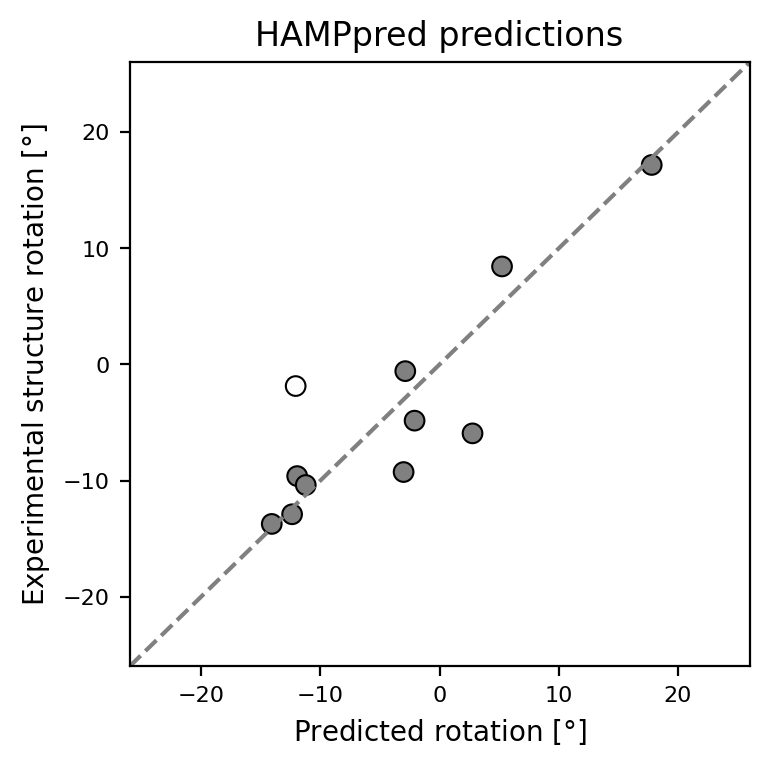

In [14]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred predictions", size=title_font_size)

In [15]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.75618170787087